## Imports and dataset

In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [2]:
from src.models.CCC import ClasBayesianNNVI
from src.attacks.BBB import mlmc_attack, fgsm_attack, kl_to_appd

from src.utils import plot_ppds

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import numpyro
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from joblib import Parallel, delayed

/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [4]:
import numpyro
numpyro.set_host_device_count(8)

In [5]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)

## MNIST - DE

In [6]:
# load MNIST data without tensorflow
from sklearn.datasets import fetch_openml

# Load MNIST from OpenML
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data.values, mnist.target.values
X = X / 255.0  # Normalize pixel values to [0, 1]
y = y.astype(int)
y = jax.nn.one_hot(y, 10)

# Split into training and testing datasets
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

In [7]:
modelVI = ClasBayesianNNVI(input_dim=X_train.shape[1], hidden_units=10)
try:
    modelVI.load('../src/models/weights/mnist/30bnnvi')
except FileNotFoundError:
    print('Not model found, fitting the model') 
    modelVI.fit(
        X_train, 
        jnp.argmax(y_train, axis=1), 
        num_steps=5000
    )
    modelVI.save('../src/models/weights/mnist/10bnnviflat')

In [8]:
# measure accuracy over the test set
y_pred = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), X_test, 100).mean(axis=0).argmax(axis=1)
accuracy = (y_pred == jnp.argmax(y_test, axis=1)).mean()
print(f"Accuracy over the test set: {accuracy * 100:.2f}%")

Accuracy over the test set: 94.15%


In [9]:
# Load notMNIST data without labels
import os
from PIL import Image
import numpy as np

# Ruta de la carpeta con imágenes
folder_path = '../data/notMNIST_small'

# Lista para almacenar las imágenes
images = []

for dirpath, dirnames, filenames in os.walk(folder_path):
    for filename in filenames:
        if filename.endswith('.png'):
            img_path = os.path.join(dirpath, filename)
            img = Image.open(img_path)
            img_gray = img.convert('L')
            img_array = np.array(img_gray)
            images.append(img_array)

X_notmnist = np.array(images).reshape(-1, 28*28) / 255.0

## Trying to break them

In [10]:
x = X_test[0]
x = jnp.array(x).reshape(1, -1)
modelVI.sample_predictive_distribution(jax.random.PRNGKey(0), x, 20).shape

(20, 1)

In [11]:
def entropy(x, pred):
    pred += 1e-8
    entr = - (pred * jnp.log(pred)).sum(axis=-1) / jnp.log(2)
    return entr.mean()

python(11786) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

Mnist mean:  2.4053907e-06
Not mnist mean:  0.049734406


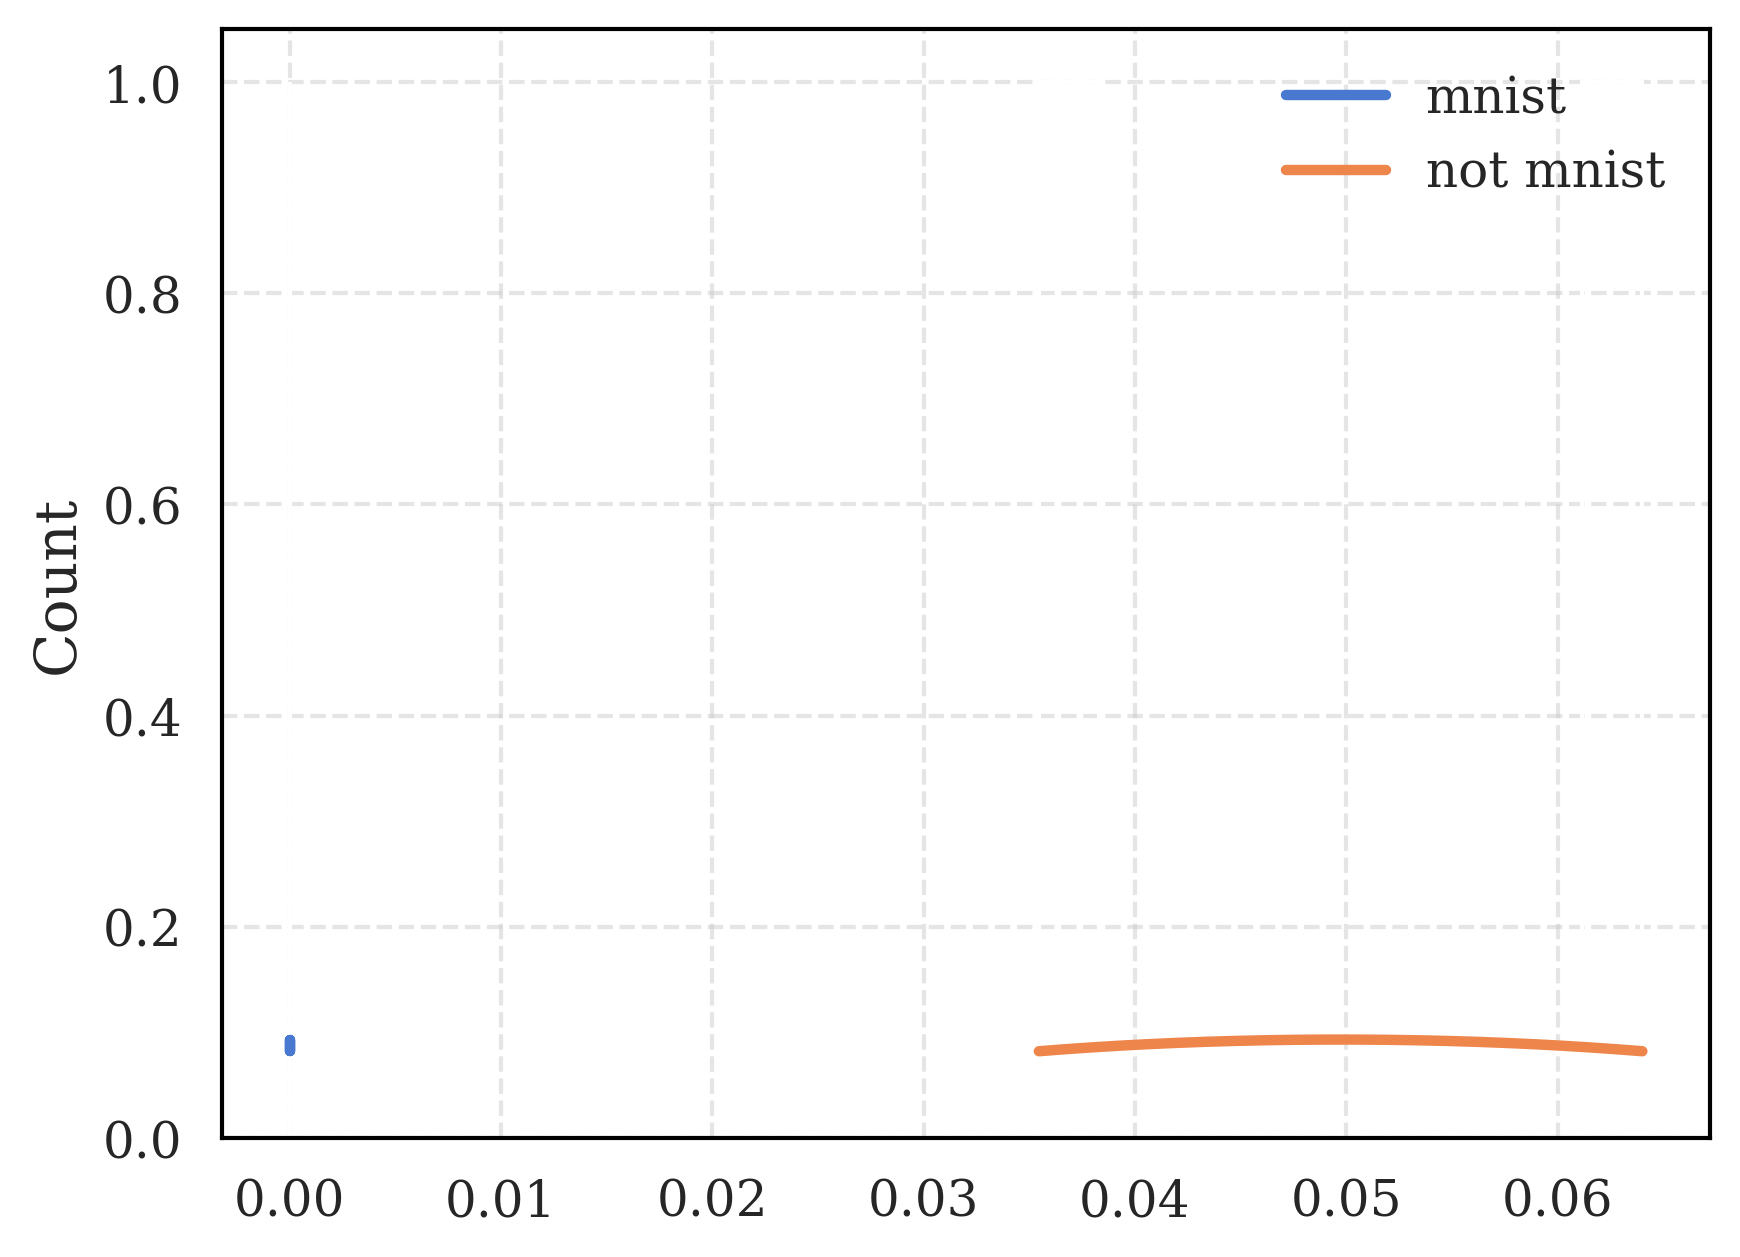

In [12]:
mnist = []
for x in tqdm(X_test[:2]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    mnist.append(entropy(x, preds))

sns.histplot(jnp.array(mnist), kde=True, bins=10, alpha=0.)

not_mnist = []
for x in tqdm(X_notmnist[:2]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    not_mnist.append(entropy(x, preds))

sns.histplot(jnp.array(not_mnist), kde=True, bins=10, alpha=0.)

legend = ['mnist', 'not mnist']
plt.legend(legend)
print('Mnist mean: ', jnp.array(mnist).mean())
print('Not mnist mean: ', jnp.array(not_mnist).mean())

  0%|          | 0/10 [00:00<?, ?it/s]

Early stopping at iteration 12


 20%|██        | 2/10 [02:44<12:42, 95.29s/it]

Early stopping at iteration 12


 30%|███       | 3/10 [02:49<06:18, 54.11s/it]

Early stopping at iteration 12


 40%|████      | 4/10 [02:53<03:25, 34.31s/it]

Early stopping at iteration 12


 50%|█████     | 5/10 [02:57<01:56, 23.31s/it]

Early stopping at iteration 99


 70%|███████   | 7/10 [05:44<03:04, 61.64s/it]

Early stopping at iteration 12


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


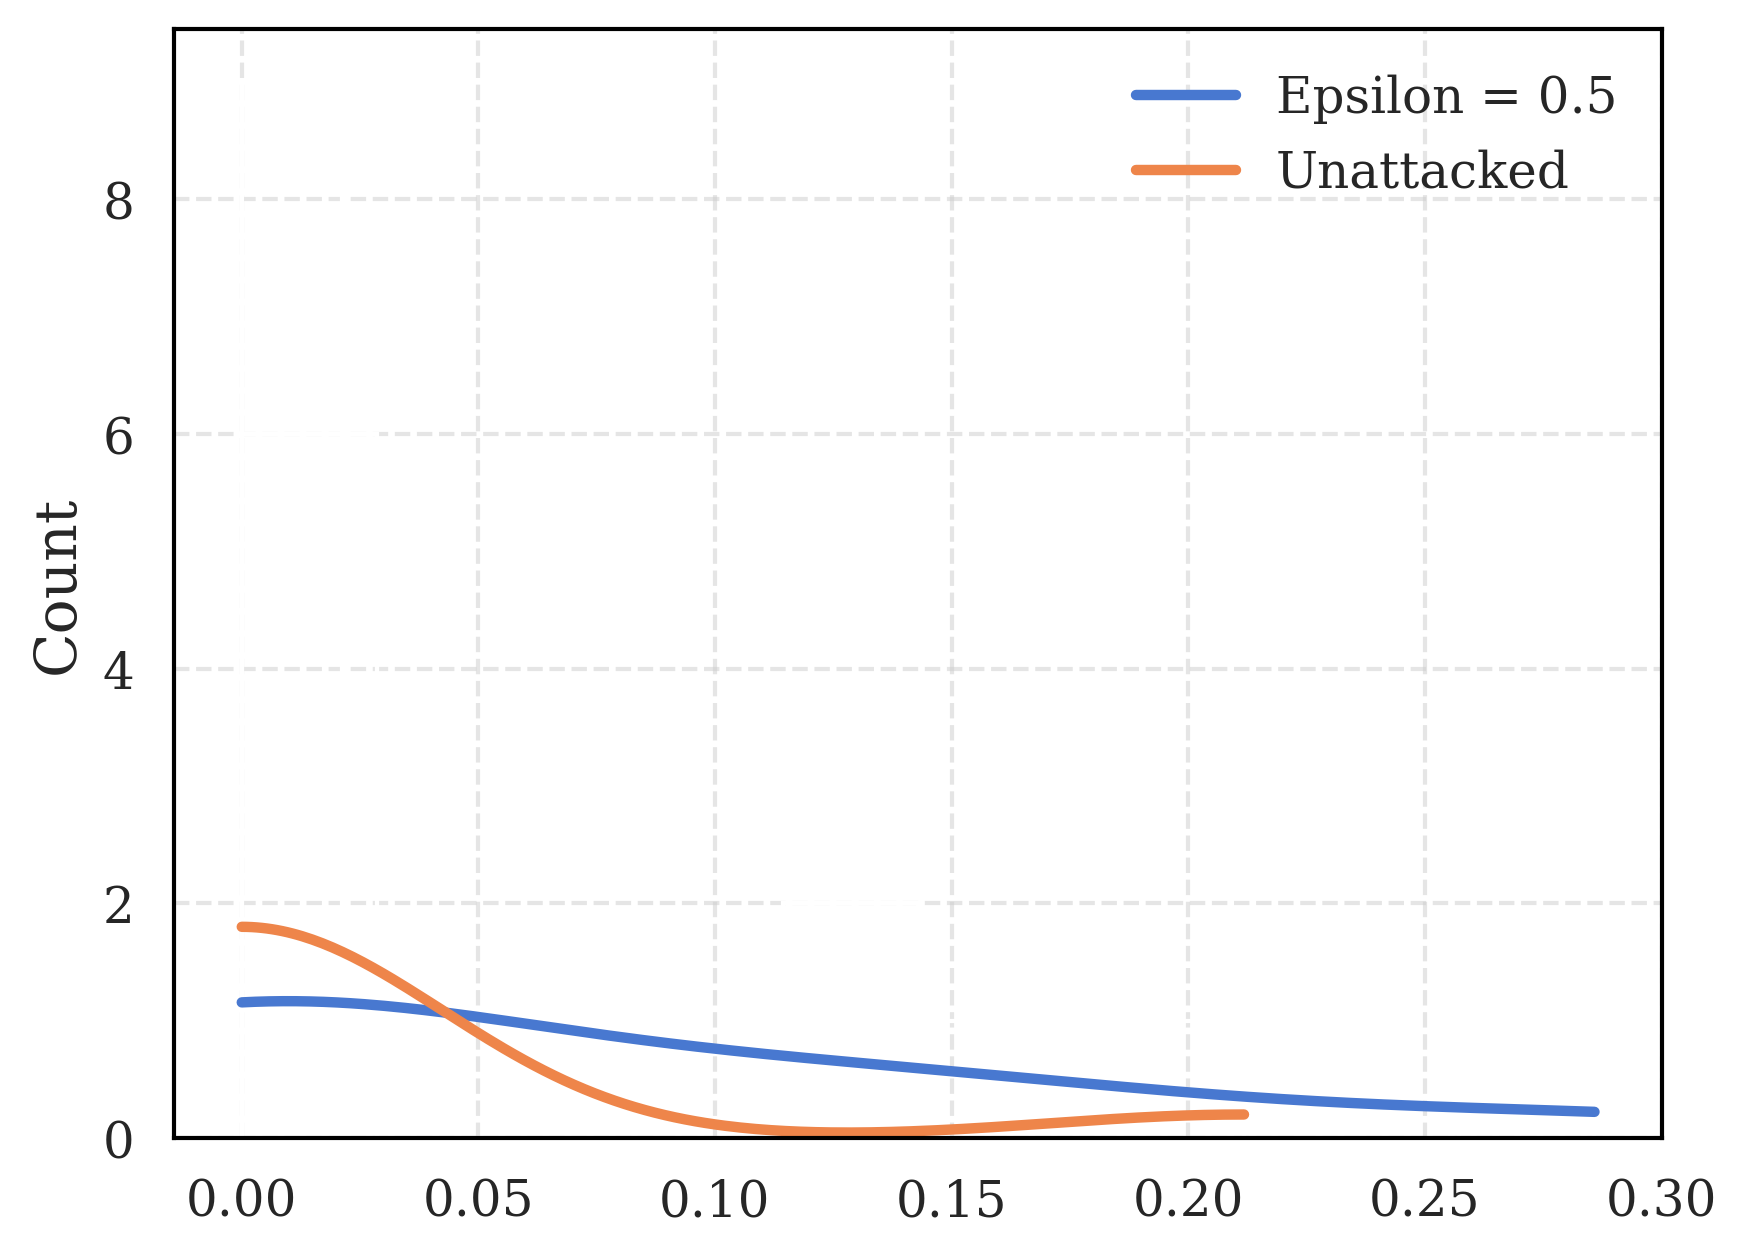

In [13]:
# Y is a uniform distribution over 10 classes
obj_appd = numpyro.distributions.Categorical(jnp.ones(10) / 10)

def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    x_adv, _ = mlmc_attack(modelVI, x, appd=obj_appd, epsilon=eps, n_iter=400, lr=0.01)
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv, 20)
    return entropy(x_adv, preds)

epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]
epsilons = [.5]
num_points = 10
for eps in epsilons:
    #entropies = Parallel(n_jobs=40)(delayed(process)(x, eps) for x in tqdm(X_test[:num_points]))
    entropies = [process(x, eps) for x in tqdm(X_test[:num_points])]
    sns.histplot(jnp.array(entropies), kde=True, bins=10, alpha=0.)
    
unattacked_entropies = []
for x in tqdm(X_test[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.histplot(jnp.array(unattacked_entropies), kde=True, bins=10, alpha=0.)
legend = ['Epsilon = ' + str(eps) for eps in epsilons] + ['Unattacked']
plt.legend(legend)

In [14]:
def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    pred = modelVI.sample_predictive_distribution(jax.random.PRNGKey(0), x, 1)  # so obj_appd is just 1 point mass on pred
    obj_appd = numpyro.distributions.Categorical(probs=jax.nn.one_hot(pred, 10))
    
    x_adv, _ = mlmc_attack(modelVI, x, appd=obj_appd, epsilon=eps, n_iter=400)
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv, 20)
    return entropy(x_adv, preds)

epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]
epsilons = [0.5]
num_points = 10
for eps in epsilons:
    #entropies = Parallel(n_jobs=40)(delayed(process)(x, eps) for x in tqdm(X_notmnist[:num_points]))  # TODO 80 points
    entropies = [process(x, eps) for x in tqdm(X_notmnist[:num_points])]
    sns.histplot(jnp.array(entropies), kde=True, bins=10, alpha=0.)

unattacked_entropies = []
for x in tqdm(X_notmnist[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution(x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.histplot(jnp.array(unattacked_entropies), kde=True, bins=10, alpha=0.)
legend = ['Epsilon = ' + str(eps) for eps in epsilons] + ['Unattacked']
plt.legend(legend)

  0%|          | 0/10 [00:54<?, ?it/s]


KeyboardInterrupt: 